In [9]:
from astropy.io import fits
import sys
import pandas as pd
from astropy.table import unique, Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc, sky_match
from numcosmo_py.external.pyssc import pyssc as PySSC
import timeit
Ncm.cfg_init()

sys.path.insert(0, "/global/homes/l/lettieri/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/l/lettieri/gcr-catalogs")
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")
from GCR import GCRQuery
table_redmapper_halos = fits.open("../forecast/DC2/catalogs/redmapper_halos.fits")[1].data

%matplotlib inline

# Cosmological Model

In [10]:
redmapper_cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_redmapper_v0.8.1")

# Taking some important information about the fiducial cosmological model and survey region
redmapper_cosmology = redmapper_cat.cosmology
sky_area = redmapper_cat.sky_area

#cosmological model
cosmo = Nc.HICosmoDEXcdm()
#cosmo.omega_x2omega_k()
#cosmo.param_set_by_name("Omegak", 0.00)
cosmo.param_set_by_name("Omegax", redmapper_cosmology.Ode0)
cosmo.param_set_by_name("H0", redmapper_cosmology.H0.value)
cosmo.param_set_by_name("Omegab", redmapper_cosmology.Ob0)
cosmo.param_set_by_name("Omegac", redmapper_cosmology.Odm0)  # 0.2603

cosmo.param_set_by_name("w", -1.0)  # -1.0

prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA", 3.0116707481421923)
prim.props.n_SA = redmapper_cosmology.n_s
reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)

#matter power spectrum
tf = Nc.TransferFuncEH()

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
psf.prepare(cosmo)

old_amplitude = np.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = np.log(
    (redmapper_cosmology.sigma8 / cosmo.sigma8(psf)) ** 2 * old_amplitude
)
print(redmapper_cosmology.sigma8, cosmo.sigma8(psf))





dist = Nc.Distance.new(2.0)
dist.prepare(cosmo)

#parameters to be fitted
cosmo.set_property("Omegac_fit", True)
cosmo.set_property("w_fit", True)
prim.set_property("ln10e10ASA_fit", True)

0.8 0.8000000000000002


# Cluster Mass-Richness and photoz model 

In [11]:
cluster_m = Nc.ClusterMassAscaso(lnRichness_min = 0 ,lnRichness_max = 6.0)
cluster_m.param_set_by_name("mup0", 4.11945317984568)
cluster_m.param_set_by_name("mup1", 1.11236863168254)
cluster_m.param_set_by_name("mup2", 0.299464198653602)
cluster_m.param_set_by_name("sigmap0", 0.471246505057074)
cluster_m.param_set_by_name("sigmap1", -0.0591674971985774)
cluster_m.param_set_by_name("sigmap2", -0.109077938873429)

cluster_m.param_set_by_name("cut", np.log(5))
'''
cluster_m.set_property("mup0_fit", True)
cluster_m.set_property("mup1_fit", True)
cluster_m.set_property("mup2_fit", True)
cluster_m.set_property("sigmap0_fit", True)
cluster_m.set_property("sigmap1_fit", True)
cluster_m.set_property("sigmap2_fit", True)
'''

cluster_z = Nc.ClusterRedshiftNodist(z_min = 0 ,z_max = 1.2)

0.9999999995026688


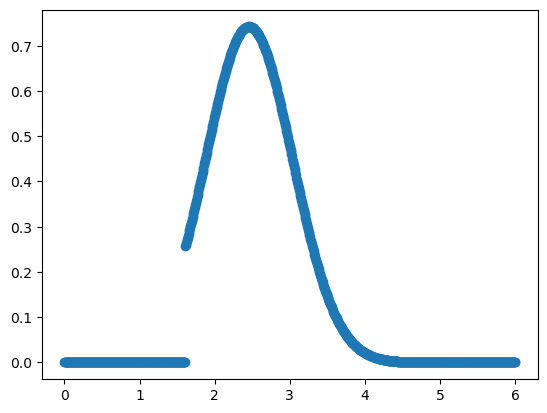

In [15]:
lnR = np.linspace(0 ,6 , 1000)
pdf = [cluster_m.p(cosmo , 14 * np.log(10) , 0.3 , [rich]) for rich in lnR]


plt.scatter(lnR , pdf)   

print(cluster_m.intp(cosmo , 14 * np.log(10) , 0.3))

# Cluster abundance model

In [13]:
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200.0)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.prepare(cosmo)
hmf.set_area(sky_area * (np.pi / 180) ** 2)
hbias_Tinker = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, None)
cad.set_area(sky_area * (np.pi / 180) ** 2)

# Cluster counts likelihood

In [14]:
rng = Ncm.RNG.seeded_new(None, 1312)
mset = Ncm.MSet.new_array([cluster_m, cosmo, cluster_z])
mset.prepare_fparam_map()
dset = Ncm.Dataset.new()

ncdata = Nc.DataClusterNCount.new(cad, "NcClusterRedshiftNodist", "NcClusterMassAscaso")
ncdata.set_init(True)
ncdata.resample(mset , rng)

dset.append_data(ncdata)

# Likelihood
lh = Ncm.Likelihood.new(dset)
lnM_obs_data = [ncdata.get_lnM_obs().get_col(0).get(i) for i in range(ncdata.get_lnM_obs().get_col(0).len())]
z_obs   = [ncdata.get_z_obs().get_col(0).get(i) for i in range(ncdata.get_z_obs().get_col(0).len())]

nbins = 100
lnM_obs = np.linspace(np.log(5) , 6.0 , nbins +1)

lnM_obs_bin = [(lnM_obs[i] +lnM_obs[i+1])/2 for i in range(len(lnM_obs)-1)]
abundance = [cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnM_obs[i]] , [lnM_obs[i+1]], None, [0] , [1.2] , None)  for i in range(len(lnM_obs)-1)]

plt.hist( lnM_obs_data, bins=nbins)
plt.plot(lnM_obs_bin , abundance)
plt.xlim(np.log(5) , 2.6)
plt.show()



AttributeError: 'DataClusterNCount' object has no attribute 'set_area'

# Fitting correct model

In [ ]:
# Fit

fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)
fit.log_info()
fit.run(Ncm.FitRunMsgs.SIMPLE)

fit.log_info()


Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(2)
fitmc.set_data_file("mc_cut.fits")

fitmc.start_run()
fitmc.run(3000)
fitmc.end_run()
fitmc.mean_covar()
fit.log_covar()

mcat = Ncm.MSetCatalog.new_from_file_ro("mc_cut.fits", 0)
mcat.log_full_covar()


#----------------------------------------------------------------------------------
# Data used:
#   - Cluster NCount resample unbinned. Generated 3398549 from mean 3.3973e+06
#        (full). Mass proxy type `NcClusterMassAscaso', redshift proxy type
#        `NcClusterRedshiftNodist'. Resampled in range [  0.0000,   1.2000]
#        [1.00000000e+12, 1.00000000e+16] and area   0.0000 degrees square.
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  71                  [FIXED]
#   -     Omegac[01]:  0.22                [FREE]
#   -     Omegax[02]:  0.7352              [FIXED]
#   -    Tgamma0[03]:  2.7245              [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.046               [FIXED]
#   -     Omegab[06]:  0.0448              [FIXED]

# Fitting uncorrect model

In [ ]:
ncdata.resample(mset , rng)
cluster_m.param_set_by_name("cut", np.log(1))

# Fit

fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)

fit.log_info()
#fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)

fit.log_info()

'''
Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.BOOTSTRAP_NOMIX , Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(2)
fitmc.set_data_file("mc_no_cut.fits")

fitmc.start_run()
fitmc.run(3000)
fitmc.end_run()
fitmc.mean_covar()
fit.log_covar()

mcat = Ncm.MSetCatalog.new_from_file_ro("mc_no_cut.fits", 0)
mcat.log_full_covar()
'''